In [1]:
# Import necessary libraries
import gmsh
import dolfinx
import os
import matplotlib.pyplot as plt
import numpy as np
import pyvista
import basix
from numba import njit, prange


from mpi4py import MPI
from petsc4py import PETSc
from basix.ufl import element
from dolfinx.cpp.mesh import to_type, cell_entity_type
from dolfinx.fem import (Constant, Function, functionspace, FunctionSpace, assemble_scalar, dirichletbc, form, locate_dofs_topological, set_bc)
from dolfinx.fem.petsc import (apply_lifting, assemble_matrix, assemble_vector, create_vector, create_matrix, set_bc)
from dolfinx.graph import adjacencylist
from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells
from dolfinx.io import VTXWriter
from dolfinx.mesh import create_mesh, meshtags_from_entities, create_unit_square
from ufl import (FacetNormal, Identity, Measure, TestFunction, TrialFunction,
                 as_vector, div, dot, ds, dx, inner, lhs, grad, nabla_grad, rhs, sym, system, SpatialCoordinate, as_tensor)
import sys
import mesh_init

import tqdm.autonotebook


In [2]:
gmsh.initialize()
gdim = 2
mesh, ft, inlet_marker, wall_marker, outlet_marker, obstacle_marker = mesh_init.create_mesh(gdim, True)


Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 5 (Ellipse)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 70%] Meshing curve 8 (Line)
Info    : [ 90%] Meshing curve 9 (Line)
Info    : Done meshing 1D (Wall 0.00115317s, CPU 0.000283s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay for Quads)
Info    : Simple recombination completed (Wall 0.000584417s, CPU 0.000351s): 30 quads, 4 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.822908, min Q = 0.303353
Info    : Simple recombination completed (Wall 0.00100083s, CPU 0.001001s): 132 quads, 0 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.854715, min Q = 0.327308
Info    : Done meshing 2D (Wall 0.00444842s, CPU 0.00225s)
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing 

In [4]:
experiment_number = 25
np_path = f'results/arrays/experiments/{experiment_number}/'
plot_path = f"plots/experiments/{experiment_number}/"

# Time stepping parameters
t = 0
T = 8.0
dt = 1 / 100 #200
num_steps = int(T / dt)
k = Constant(mesh, PETSc.ScalarType(dt))

N = 5 #2000
Wi = 1 #0.5
b = 60 #12#10 #60
d = 2.0
gamma = 0.5  #0.59 #1.0
ReWi = 1.0
C = ((b + d + 2) / b) * ((1-gamma)/ Wi)
num_vertices = mesh.topology.index_map(mesh.topology.dim).size_local + mesh.topology.index_map(mesh.topology.dim).num_ghosts

vs = 0.00018 #0.001 #0.00018
vp = 0.00002 #0.000 #0.00002
vis = vs + vp
b_n = vs / vis
U_n = 1
L_n = 0.1 # TODO: usually needs to be 0.1
beta = Constant(mesh, PETSc.ScalarType(1 - b_n))  # solvent ratio
mu = Constant(mesh, PETSc.ScalarType(vis))  # Dynamic viscosity
Re_n = (U_n * L_n) / vis
Re = Constant(mesh, PETSc.ScalarType(Re_n))
rho = Constant(mesh, PETSc.ScalarType(1))  # Density
U = Constant(mesh, PETSc.ScalarType(U_n))  # mean velocity
L = Constant(mesh, PETSc.ScalarType(L_n))  # characteristic length

alpha = 0.01

if mesh.comm.rank == 0:
    if not os.path.exists(np_path):
        os.makedirs(np_path, exist_ok=True)

if mesh.comm.rank == 0:
    if not os.path.exists(plot_path):
        os.makedirs(plot_path, exist_ok=True)

with open(np_path + "variables.txt", "w") as text_file:
    text_file.write("fluid viscosity: %s \n" % vs)
    text_file.write("polymer viscosity: %s \n" % vp)
    text_file.write("Reynolds Number: %s \n" % Re_n)
    text_file.write("Weissenberg Number: %s \n" % Wi)
    text_file.write("Max Extension: %s \n" % b)
    text_file.write("dt: %s \n" % dt)
    text_file.write("T: %s \n" % T)
    text_file.write("beta: %s" % (1 - b_n))



In [5]:
sqrt_delta_t = np.sqrt(dt)
sqrt_1_Wi = np.sqrt(1 / Wi)

@njit(fastmath=True)
def F(Q, b):
    norm_Q = np.sqrt(np.sum(Q**2, axis=1)) 
    return Q / (1 - (norm_Q[:, np.newaxis]**2 / b)) 

@njit(fastmath=True)
def velocity_gradient(x):
    grad = np.zeros((2, 2), dtype=np.float64)
    grad[0, 0] = 1 - 2 * x[1]  # x[1] corresponds to y here
    grad[1, 0] = 0
    grad[0, 1] = 0
    grad[1, 1] = 0
    return grad

@njit(fastmath=True)
def compute_velocity_at_point(y):
    u_x = y - y ** 2  # y - y^2
    u_y = 0.0
    return np.array([u_x, u_y])

@njit(fastmath=True)
def compute_gradient(Q, dx):
    grad = np.zeros_like(Q)
    grad[1:-1] = (Q[2:] - Q[:-2]) / (2 * dx)
    grad[0] = (Q[1] - Q[0]) / dx
    grad[-1] = (Q[-1] - Q[-2]) / dx
    return grad

#@njit(fastmath=True)
#def compute_advection_term(Q, velocity, dx):
    advection_term = np.zeros(Q.shape)
    grad_Q = compute_gradient(Q, dx)
    for i in range(Q.shape[1]):
        advection_term[:, i] = velocity[i] * grad_Q[:, i]
    return advection_term

@njit(fastmath=True, parallel=True)
def euler_maruyama_nonhomogeneous(Q0, delta_t, M, random_numbers, Wi, b, y, velocity, sqrt_delta_t, sqrt_1_Wi):
    N, D = Q0.shape
    Q_traj = np.zeros((N, M + 1, D))
    Q_traj[:, 0, :] = Q0
    kappa_T = np.zeros((2, 2), dtype=np.float64)
    kappa_T[0, 0] = 1 - 2 * y

    for n in prange(M):
        dW = random_numbers[:, n, :] * sqrt_delta_t
        F_Q = np.zeros_like(Q_traj[:, n, :])
        norm_Q = np.sqrt(np.sum(Q_traj[:, n, :] ** 2, axis=1))
        for i in range(N):
            F_Q[i] = Q_traj[i, n, :] / (1 - (norm_Q[i] ** 2 / b))

        Q_dot = np.dot(Q_traj[:, n, :], kappa_T.T) - (1 / (2 * Wi)) * F_Q

        # Compute advection term
        advection_term = np.zeros((N, D))
        for i in range(N):
            grad_Q0 = compute_gradient(Q_traj[:, n, 0], 0.01851243850807551)  # dx 
            grad_Q1 = compute_gradient(Q_traj[:, n, 1], 0.01851243850807551)
            advection_term[i, 0] = velocity[0] * grad_Q0[i]
            advection_term[i, 1] = velocity[1] * grad_Q1[i]

        Q_traj[:, n + 1, :] = Q_traj[:, n, :] + Q_dot * delta_t + sqrt_1_Wi * dW - advection_term * delta_t

    return Q_traj

@njit(fastmath=True)
def compute_polymer_stress_tensor(Q_traj_samples, N, M, Wi, b, C):
    sum_dyadic_product = np.zeros((2, 2))
    for n in prange(M + 1):
        Q_traj = Q_traj_samples[:, n, :]
        norm_Q_traj = np.sqrt(np.sum(Q_traj**2, axis=1))
        F_Q_traj = Q_traj / (1 - (norm_Q_traj[:, np.newaxis] ** 2 / b))
        for i in prange(N):
            sum_dyadic_product[0, 0] += Q_traj[i, 0] * F_Q_traj[i, 0]
            sum_dyadic_product[0, 1] += Q_traj[i, 0] * F_Q_traj[i, 1]
            sum_dyadic_product[1, 0] += Q_traj[i, 1] * F_Q_traj[i, 0]
            sum_dyadic_product[1, 1] += Q_traj[i, 1] * F_Q_traj[i, 1]
    tau_np = C * (sum_dyadic_product / N)
    return tau_np


In [13]:
#from scipy.spatial import KDTree
#vertex_coordinates = mesh.geometry.x[:, :2]  # Extract the vertex coordinates

# Function to compute the distance to the nearest neighbor for each vertex
#def compute_nearest_neighbor_distances(vertex_coordinates):
#    tree = KDTree(vertex_coordinates)
#    distances, _ = tree.query(vertex_coordinates, k=2)  # k=2 to find the distance to the nearest neighbor
#    nearest_neighbor_distances = distances[:, 1]  # The first column is the distance to the point itself, so take the second column
#    return nearest_neighbor_distances

# Compute the nearest neighbor distances for all vertices
#nearest_neighbor_distances = compute_nearest_neighbor_distances(vertex_coordinates)

# Calculate the average distance
#average_dx = np.mean(nearest_neighbor_distances)

#print(f"Average dx: {average_dx}")

Average dx: 0.01851243850807551


In [6]:
np.random.seed(42)
Q0 = np.random.normal(0.0, 0.1, (N, 2))
random_numbers = np.random.normal(size=(N, num_steps, 2))

v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim,))
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
V = functionspace(mesh, v_cg2)
Q = functionspace(mesh, s_cg1)

fdim = mesh.topology.dim - 1

class InletVelocity():
    def __init__(self, t):
        self.t = t

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]), dtype=PETSc.ScalarType)
        #values[0] = 4 * 1.5 * np.sin(self.t * np.pi / 8) * x[1] * (0.41 - x[1]) / (0.41 ** 2)
        #values[0] = 2 * 1.5 * (1 - np.cos(self.t * np.pi / 4)) * x[1] * (0.41 - x[1]) / (0.41 ** 2)
        if self.t < 2:
            values[0] = 2 * 1.5 * (1 - np.cos(self.t * np.pi / 2)) * x[1] * (0.41 - x[1]) / (0.41 ** 2)
        else:
            values[0] = 6 * x[1] * (0.41 - x[1]) / (0.41 ** 2)
        return values
    
# Inlet
u_inlet = Function(V)
inlet_velocity = InletVelocity(t)
u_inlet.interpolate(inlet_velocity)
bcu_inflow = dirichletbc(u_inlet, locate_dofs_topological(V, fdim, ft.find(inlet_marker)))
# Walls
u_nonslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
bcu_walls = dirichletbc(u_nonslip, locate_dofs_topological(V, fdim, ft.find(wall_marker)), V)

# Obstacle
bcu_obstacle = dirichletbc(u_nonslip, locate_dofs_topological(V, fdim, ft.find(obstacle_marker)), V)
bcu = [bcu_inflow, bcu_obstacle, bcu_walls]

# Outlet
bcp_outlet = dirichletbc(PETSc.ScalarType(0), locate_dofs_topological(Q, fdim, ft.find(outlet_marker)), Q)
bcp = [bcp_outlet]



# Function spaces for velocity and pressure
u = TrialFunction(V)
v = TestFunction(V)
u_ = Function(V)
u_.name = "u"
u_s = Function(V)
u_n = Function(V)
u_n1 = Function(V)
p = TrialFunction(Q)
q = TestFunction(Q)
p_ = Function(Q)
p_.name = "p"
phi = Function(Q)

# Initialize tau function space
element = basix.ufl.element("Lagrange", mesh.topology.cell_name(), 1, shape=(2, 2))
V_tau = functionspace(mesh, element)
tau = Function(V_tau)

n = FacetNormal(mesh) # ?????????
f = Constant(mesh, PETSc.ScalarType((0, 0)))

div_tau = dot(div(tau), v)

F1 = Re / k * dot(u - u_n, v) * dx
F1 += Re * inner(dot(1.5 * u_n - 0.5 * u_n1, 0.5 * nabla_grad(u + u_n)), v) * dx
F1 += (1 - beta) * 0.5 * inner(grad(u + u_n), grad(v)) * dx - dot(p_, div(v)) * dx
F1 -= div_tau * dx  # extra stress
F1 -= dot(f, v) * dx

a1 = form(lhs(F1))
L1 = form(rhs(F1))
A1 = create_matrix(a1)
b1 = create_vector(L1)

a2 = form(dot(grad(p), grad(q)) * dx)
L2 = form(-Re / k * dot(div(u_s), q) * dx)
A2 = assemble_matrix(a2, bcs=bcp)
A2.assemble()
b2 = create_vector(L2)

a3 = form(Re * dot(u, v) * dx)
L3 = form(Re * dot(u_s, v) * dx - k * dot(nabla_grad(phi), v) * dx)
A3 = assemble_matrix(a3)
A3.assemble()
b3 = create_vector(L3)



In [7]:
# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.JACOBI)

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm)
solver2.setOperators(A2)
solver2.setType(PETSc.KSP.Type.MINRES)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm)
solver3.setOperators(A3)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)



In [8]:
n = -FacetNormal(mesh)  # Normal pointing out of obstacle
dObs = Measure("ds", domain=mesh, subdomain_data=ft, subdomain_id=obstacle_marker)
dout = Measure("ds", domain=mesh, subdomain_data=ft, subdomain_id=outlet_marker)
outlet_impulse = form(u_[0] * dout)
u_t = inner(as_vector((n[1], -n[0])), u_)
drag = form(2 / (Re * mu * 1.0) * (rho * vis * inner(grad(u_t), n) * n[1] - p_ * n[0]) * dObs)  # 0.1
lift = form(-2 / (Re * mu * 1.0) * (rho * vis * inner(grad(u_t), n) * n[0] + p_ * n[1]) * dObs)  # 0.1


In [9]:
if mesh.comm.rank == 0:
    C_D = np.zeros(num_steps, dtype=PETSc.ScalarType)
    C_L = np.zeros(num_steps, dtype=PETSc.ScalarType)
    C_S = np.zeros(num_steps, dtype=PETSc.ScalarType)
    #C_T = np.zeros(num_steps, dtype=PETSc.ScalarType)
    t_u = np.zeros(num_steps, dtype=np.float64)
    t_p = np.zeros(num_steps, dtype=np.float64)

if mesh.comm.rank == 0:
    t_u = np.zeros(num_steps, dtype=np.float64)
    t_p = np.zeros(num_steps, dtype=np.float64)

tree = bb_tree(mesh, mesh.geometry.dim)
points = np.array([[0.15, 0.2, 0], [0.25, 0.2, 0]])
cell_candidates = compute_collisions_points(tree, points)
colliding_cells = compute_colliding_cells(mesh, cell_candidates, points)
front_cells = colliding_cells.links(0)
back_cells = colliding_cells.links(1)
if mesh.comm.rank == 0:
    p_diff = np.zeros(num_steps, dtype=PETSc.ScalarType)


In [10]:
vertex_coordinates = mesh.geometry.x
#x = SpatialCoordinate(mesh)
x = np.zeros(2)  # Placeholder for the spatial coordinate
progress = tqdm.autonotebook.tqdm(desc="Solving PDE", total=num_steps)

u_sol_1 = []
u_sol_2 = []
u_magnitude = []

tau_11_values = []
tau_12_values = []
tau_21_values = []
tau_22_values = []


Solving PDE:   0%|          | 0/800 [00:00<?, ?it/s]

In [11]:

for step in range(num_steps):
    progress.update(1)
    t += dt
    inlet_velocity.t = t
    u_inlet.interpolate(inlet_velocity)

    tau_np = np.zeros((num_vertices, 2, 2))
    for i in prange(num_vertices):
        x[:] = vertex_coordinates[i, :2]  # Extract the spatial coordinates
        y = x[1]  # Extract y-coordinate for the velocity field
        velocity = compute_velocity_at_point(y)
        Q_traj_samples = euler_maruyama_nonhomogeneous(Q0, dt, num_steps, random_numbers, Wi, b, y, velocity, sqrt_delta_t, sqrt_1_Wi)
        tau_np[i, :, :] = compute_polymer_stress_tensor(Q_traj_samples, N, num_steps, Wi, b, C)
    
    # Update tau vector
    for i in range(num_vertices):
        for j in range(2):
            for k in range(2):
                tau.vector[i * 4 + j * 2 + k] = tau_np[i, j, k]
    tau.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

    # Step 1: Tentative velocity step
    A1.zeroEntries()
    assemble_matrix(A1, a1, bcs=bcu)
    A1.assemble()
    with b1.localForm() as loc:
        loc.set(0)
    assemble_vector(b1, L1)
    apply_lifting(b1, [a1], [bcu])
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b1, bcu)
    solver1.solve(b1, u_s.vector)
    u_s.x.scatter_forward()

    # Step 2: Pressure correction step
    with b2.localForm() as loc:
        loc.set(0)
    assemble_vector(b2, L2)
    apply_lifting(b2, [a2], [bcp])
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b2, bcp)
    solver2.solve(b2, phi.vector)
    phi.x.scatter_forward()

    p_.vector.axpy(1, phi.vector)
    p_.x.scatter_forward()

    # Step 3: Velocity correction step
    with b3.localForm() as loc:
        loc.set(0)
    assemble_vector(b3, L3)
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    solver3.solve(b3, u_.vector)
    u_.x.scatter_forward()

    laenge = int(u_.x.array.shape[0] / 2)
    u_gen_1 = (u_.x.array[2 * k] for k in range(laenge))
    u_gen_2 = (u_.x.array[2 * k + 1] for k in range(laenge))
    u_sol_1.append(list(u_gen_1))
    u_sol_2.append(list(u_gen_2))
    u_mag_gen = (np.sqrt((u_.x.array[2 * k]) ** 2 + (u_.x.array[2 * k + 1]) ** 2) for k in range(laenge))
    u_magnitude.append(list(u_mag_gen))

    # Write solutions to file
    # vtx_u.write(t)
    # vtx_p.write(t)

    # Update variable with solution form this time step
    with u_.vector.localForm() as loc_, u_n.vector.localForm() as loc_n, u_n1.vector.localForm() as loc_n1:
        loc_n.copy(loc_n1)
        loc_.copy(loc_n)

    # Compute physical quantities
    # For this to work in parallel, we gather contributions from all processors
    # to processor zero and sum the contributions.
    drag_coeff = mesh.comm.gather(assemble_scalar(drag), root=0)
    lift_coeff = mesh.comm.gather(assemble_scalar(lift), root=0)
    #tau_coeff = mesh.comm.gather(assemble_scalar(form(div_tau * dx)), root=0)
    outlet_impulse_coeff = mesh.comm.gather(assemble_scalar(outlet_impulse), root=0)
    p_front = None
    if len(front_cells) > 0:
        p_front = p_.eval(points[0], front_cells[:1])
    p_front = mesh.comm.gather(p_front, root=0)
    p_back = None
    if len(back_cells) > 0:
        p_back = p_.eval(points[1], back_cells[:1])
    p_back = mesh.comm.gather(p_back, root=0)
    if mesh.comm.rank == 0:
        t_u[step] = t
        t_p[step] = t - dt / 2
        C_D[step] = sum(drag_coeff)
        C_L[step] = sum(lift_coeff)
        #C_T[step] = sum(tau_coeff)
        C_S[step] = sum(outlet_impulse_coeff)
        # Choose first pressure that is found from the different processors
        for pressure in p_front:
            if pressure is not None:
                p_diff[step] = pressure[0]
                break
        for pressure in p_back:
            if pressure is not None:
                p_diff[step] -= pressure[0]
                break
# vtx_u.close()
# vtx_p.close()


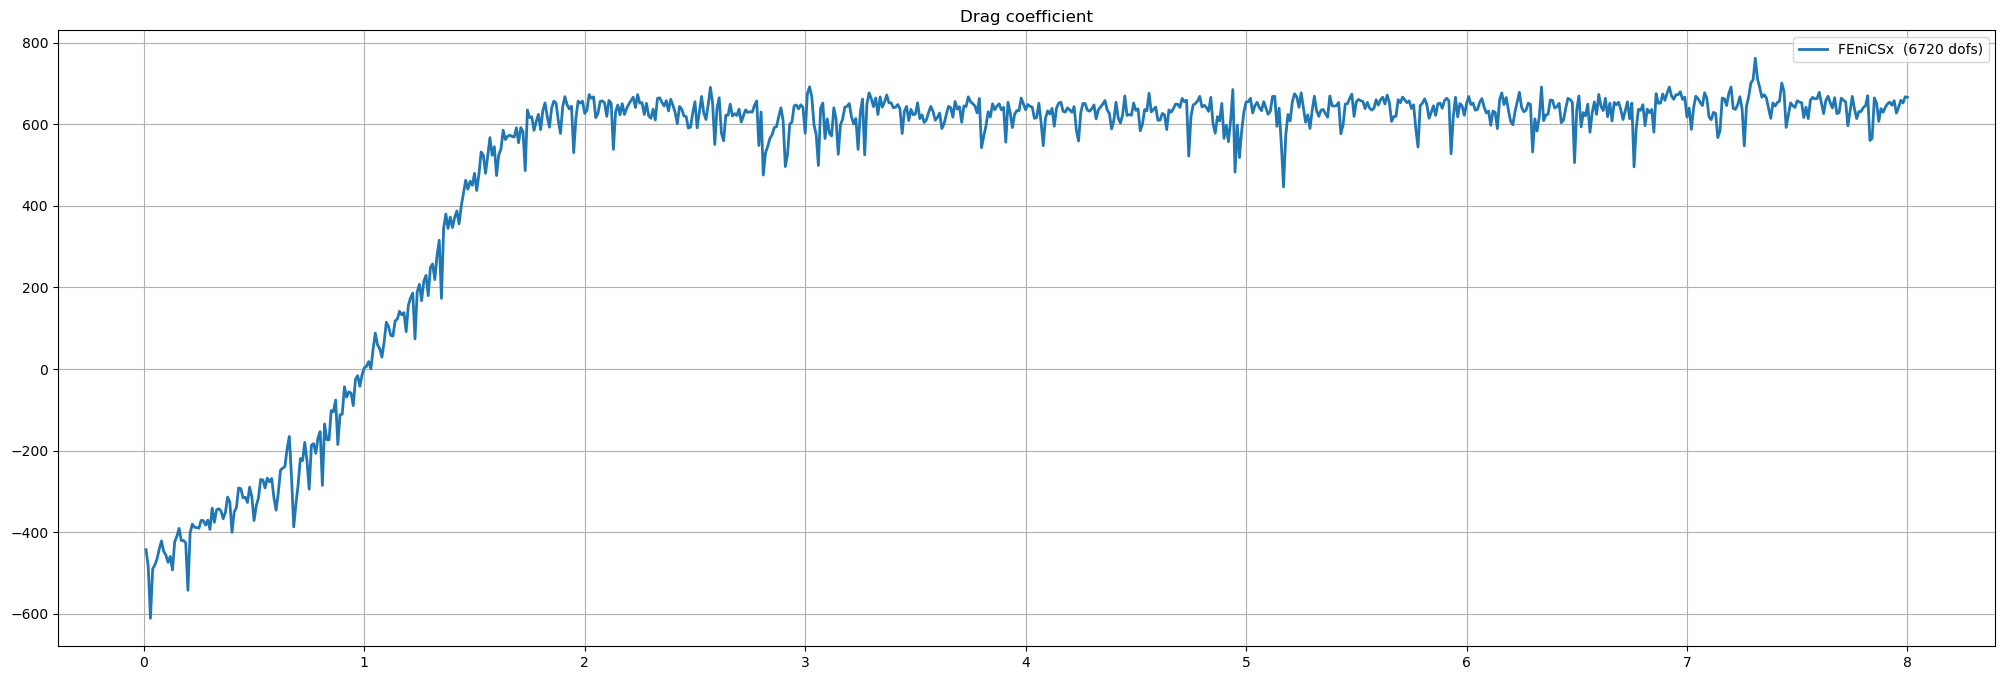

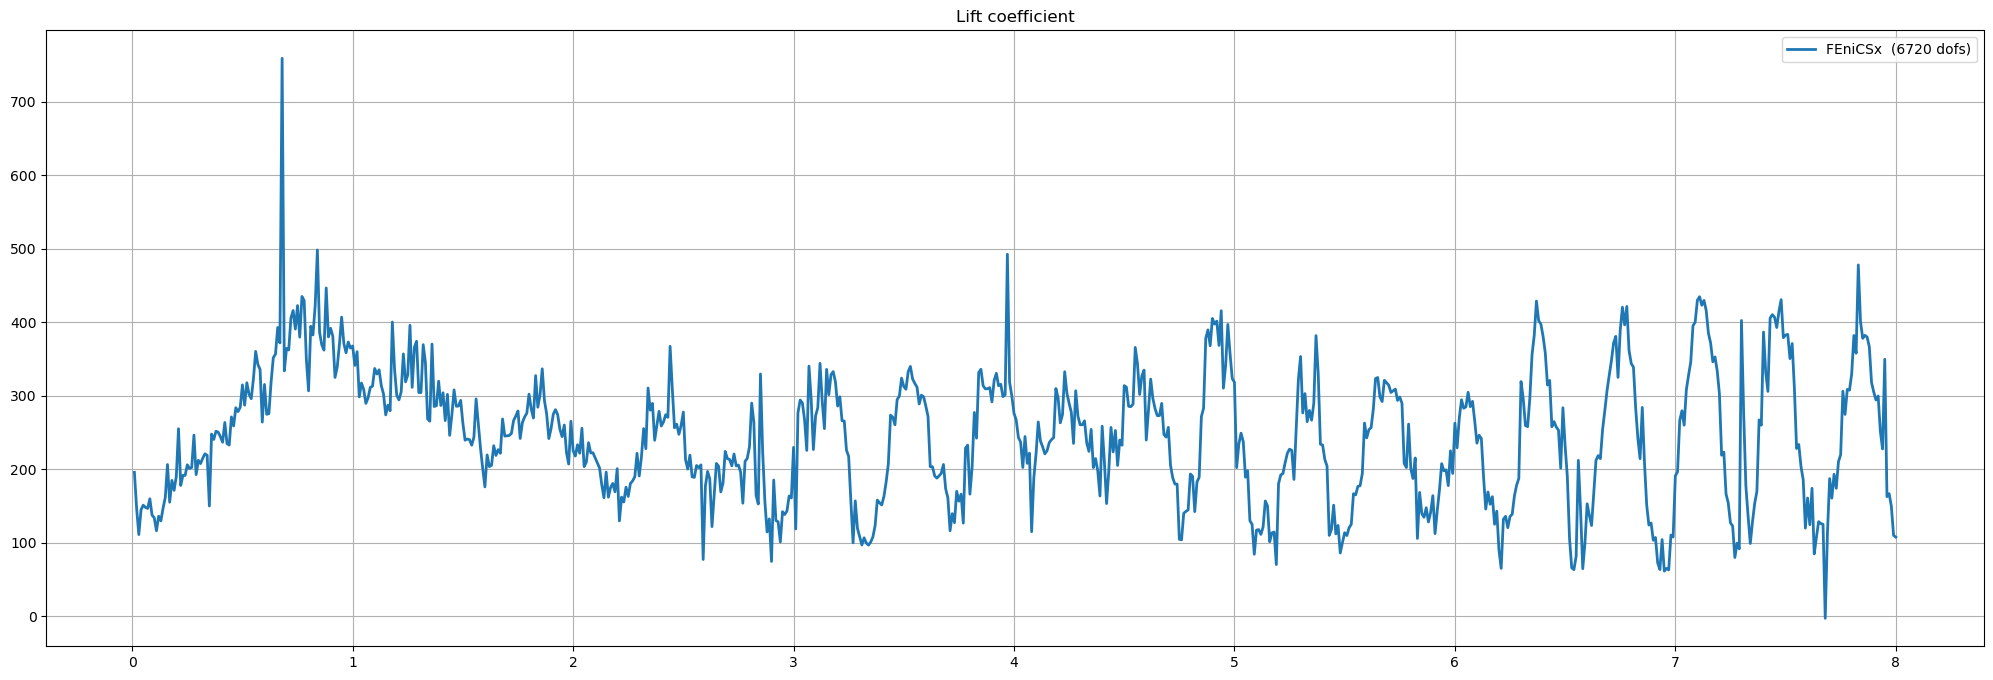

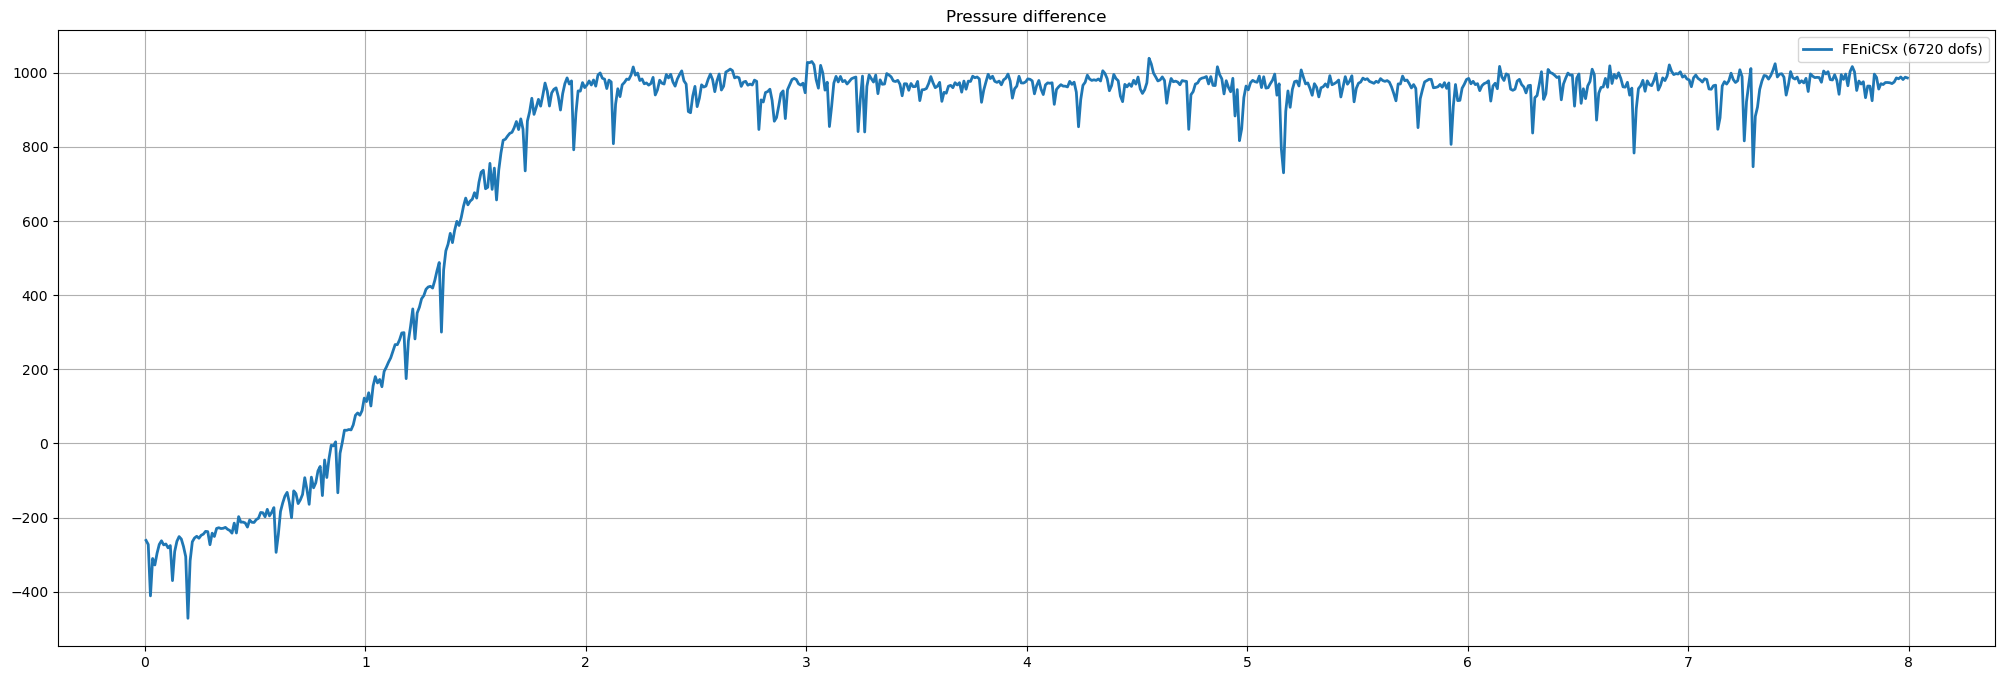

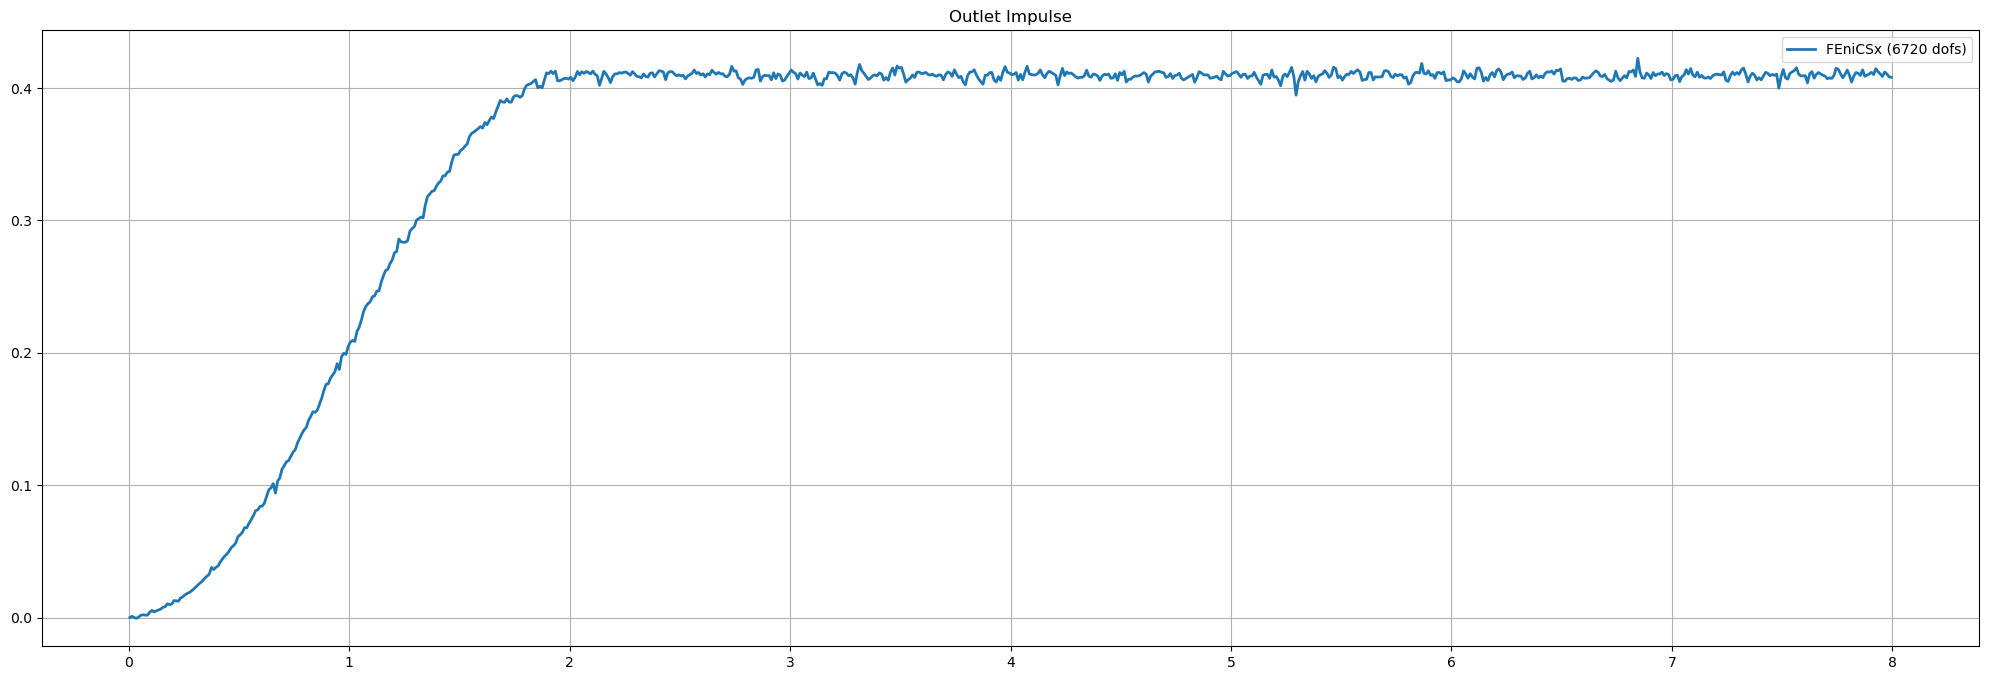

In [12]:

if mesh.comm.rank == 0:
    if not os.path.exists(np_path):
        os.makedirs(np_path, exist_ok=True)

output_dir = "results/arrays/experiments/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

with open(np_path + 'u1.npy', 'wb') as f:
    np.save(f, np.array(u_sol_1))
with open(np_path + 'u2.npy', 'wb') as f:
    np.save(f, np.array(u_sol_2))
with open(np_path + 'u_mag.npy', 'wb') as f:
    np.save(f, np.array(u_magnitude))

with open(np_path + 'drag_coeff.npy', 'wb') as f:
    np.save(f, np.array(C_D))
with open(np_path + 'lift_coeff.npy', 'wb') as f:
    np.save(f, np.array(C_L))
with open(np_path + 'pressure_coeff.npy', 'wb') as f:
    np.save(f, np.array(p_diff))
#with open(np_path + 'tau_array.npy', 'wb') as f:
    #np.save(f, np.array(C_T))
with open(np_path + 'u_time.npy', 'wb') as f:
    np.save(f, np.array(t_u))
with open(np_path + 'p_time.npy', 'wb') as f:
    np.save(f, np.array(t_p))
    

if mesh.comm.rank == 0:
    if not os.path.exists("results/figures"):
        os.mkdir("results/figures")
    num_velocity_dofs = V.dofmap.index_map_bs * V.dofmap.index_map.size_global
    num_pressure_dofs = Q.dofmap.index_map_bs * V.dofmap.index_map.size_global

    fig = plt.figure(figsize=(25, 8))
    l1 = plt.plot(t_u, C_D, label=r"FEniCSx  ({0:d} dofs)".format(num_velocity_dofs + num_pressure_dofs), linewidth=2)
    plt.title("Drag coefficient")
    plt.grid()
    plt.legend()
    plt.savefig(plot_path + "drag_comparison.png")

    fig = plt.figure(figsize=(25, 8))
    l1 = plt.plot(t_u, C_L, label=r"FEniCSx  ({0:d} dofs)".format(
        num_velocity_dofs + num_pressure_dofs), linewidth=2)
    plt.title("Lift coefficient")
    plt.grid()
    plt.legend()
    plt.savefig(plot_path + "lift_comparison.png")

    fig = plt.figure(figsize=(25, 8))
    l1 = plt.plot(t_p, p_diff, label=r"FEniCSx ({0:d} dofs)".format(num_velocity_dofs + num_pressure_dofs), linewidth=2)
    plt.title("Pressure difference")
    plt.grid()
    plt.legend()
    plt.savefig(plot_path + "pressure_comparison.png")


    fig = plt.figure(figsize=(25, 8))
    l1 = plt.plot(t_p, C_S, label=r"FEniCSx ({0:d} dofs)".format(num_velocity_dofs + num_pressure_dofs), linewidth=2)
    plt.title("Outlet Impulse")
    plt.grid()
    plt.legend()
    plt.savefig(plot_path + "impulse_comparison.png")

    #fig = plt.figure(figsize=(25, 8))
    #l1 = plt.plot(t_p, C_T, label=r"FEniCSx ({0:d} dofs)".format(num_velocity_dofs + num_pressure_dofs), linewidth=2)
    #plt.title("Summed tau")
    #plt.grid()
    #plt.legend()
    #plt.savefig(plot_path + "tau.png")
    
with dolfinx.io.VTXWriter(MPI.COMM_WORLD, np_path + f"{experiment_number}_{str(b_n)}_pressure.bp", [p_], engine="BP4") as vtx:
    vtx.write(0.0)
with dolfinx.io.VTXWriter(MPI.COMM_WORLD, np_path + f"{experiment_number}_{str(b_n)}_u.bp", [u_], engine="BP4") as vtx:
    vtx.write(0.0)